## Step 1. Import Library

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import SGD, Adam

## Step 2. Read Data

In [2]:
df = pd.read_csv('/kaggle/input/score-dataset/cleaned_data.csv')
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,1,3,1,1,2,2,1,4,1,1,87,93,91
1,1,2,4,1,1,1,2,1,0,1,0,76,78,75
2,0,1,4,1,0,3,0,0,1,0,0,85,93,89
3,1,1,4,0,1,1,2,1,1,0,2,41,43,39
4,1,3,2,0,0,2,2,0,3,0,2,65,64,68


In [3]:
df['WklyStudyHours'].value_counts()

WklyStudyHours
0    10405
1     5313
2     3337
Name: count, dtype: int64

In [4]:
# Select features and target variable
X = df[['MathScore', 'ReadingScore', 'WritingScore']].values
y = df['WklyStudyHours'].values

# Assuming X_train and y_train are your feature and target variables
X_undersampled, y_undersampled = RandomUnderSampler(random_state=42).fit_resample(X, y)

# Check the class distribution after undersampling
class_distribution = pd.Series(y_undersampled).value_counts()

# Display the class distribution
print(class_distribution)

0    3337
1    3337
2    3337
Name: count, dtype: int64


In [5]:
# Select features and target variable
X = df[['MathScore', 'ReadingScore', 'WritingScore']].values
y = df['WklyStudyHours'].values

# Split data into training and testing sets
# Split data
x_train, x_temp, y_train, y_temp = train_test_split(X_undersampled, y_undersampled, train_size=0.8, shuffle = True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle = True)

# Check the resulting shapes to ensure correct split
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (8008, 3), y_train: (8008,)
x_val: (1001, 3), y_val: (1001,)
x_test: (1002, 3), y_test: (1002,)


## Step 3. Build Neural Network

In [6]:
target_class = len(df['WklyStudyHours'].unique())
print(target_class)

3


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(x_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(32, activation='selu'),  # Hidden layer with 64 neurons
    tf.keras.layers.Dense(16, activation='selu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(target_class, activation='softmax')  # Output layer
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 707 (2.76 KB)

 Trainable params: 707 (2.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(x_train, 
                    y_train, 
                    epochs=200, 
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks = [early_stopping, reduce_lr])

Epoch 1/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3427 - loss: 6.5205 - val_accuracy: 0.3696 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3461 - loss: 1.1171 - val_accuracy: 0.3596 - val_loss: 1.1354 - learning_rate: 0.0010
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3535 - loss: 1.1296 - val_accuracy: 0.3317 - val_loss: 1.1369 - learning_rate: 0.0010
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3535 - loss: 1.1201 - val_accuracy: 0.3646 - val_loss: 1.1226 - learning_rate: 0.0010
Epoch 5/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3566 - loss: 1.1100 - val_accuracy: 0.3447 - val_loss: 1.1045 - learning_rate: 2.0000e-04
Epoch 6/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3745 - loss: 1.0949 - val_accuracy: 0.3646 - val_loss: 1.0963 - learning_rate: 2.0000e-04
Epoch 7/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3792 - 

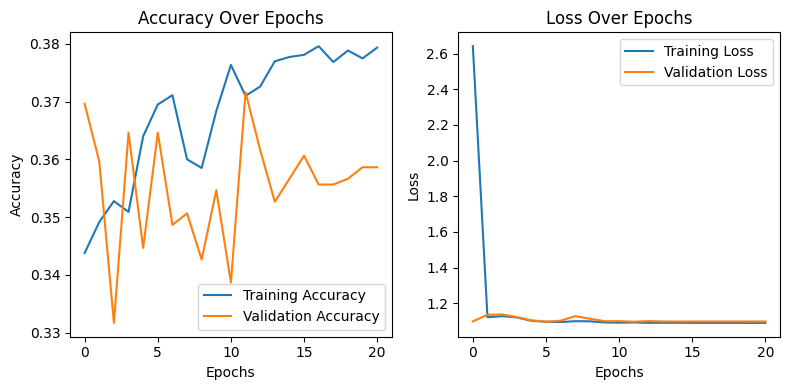

In [10]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # Create a 1x2 grid, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Step 4. Evaluation

In [11]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 40.72%


<Axes: >

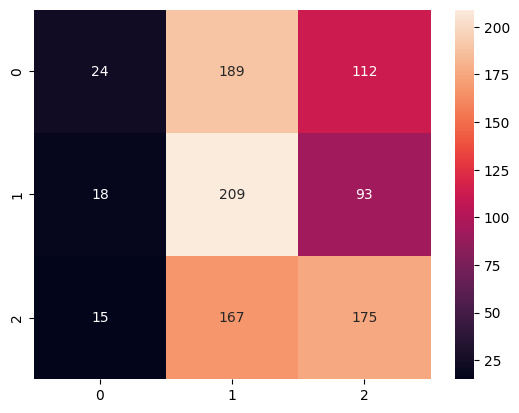

In [12]:
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='g')

In [13]:
print("Classification Report:\n", classification_report(y_pred_classes, y_test))
# Mapping for WklyStudyHours: {'5-10': 0, '< 5': 1, '> 10': 2}

Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.42      0.13        57
           1       0.65      0.37      0.47       565
           2       0.49      0.46      0.47       380

    accuracy                           0.41      1002
   macro avg       0.41      0.42      0.36      1002
weighted avg       0.56      0.41      0.45      1002



**Explanation**

The model's accuracy only reaching 41% could be due to the following reasons:
- There may not be a strong relationship between MathScore, ReadingScore, WritingScore, and WklyStudyHours, making it difficult for the model to identify meaningful patterns.
- WklyStudyHours (y) might be independent of MathScore, ReadingScore, and WritingScore (X), meaning the predictors lack relevance to the target variable.

## Step 5. Save Model

In [14]:
!pip install tensorflowjs

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.1.0 which is incompatible.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.
pandas-gbq 0.23.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.


In [15]:
import tensorflowjs as tfjs

# Save the model in HDF5 format
model.save('model_3b.h5')

# Save model in .keras format
model.save('model_3b.keras')

# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'model_3b_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


In [16]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to .tflite file
with open('model_3b.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpqc7d5wqj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135742802060464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802059232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802060992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802065392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802058000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802066976: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [17]:
model.export('saved_model_3b')

Saved artifact at 'saved_model_3b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135742802060464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802059232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802060992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802065392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802058000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742802066976: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Step 6. Try Other Classification Algorithm

#### Common Classification Algorithm

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [19]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machines', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier())
]

# Function for evaluate model
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Train and evaluate model
results = []
for name, model in models:
    model.fit(x_train, y_train)
    accuracy, precision, recall, f1 = evaluate_model(model, x_test,y_test)
    results.append([name, accuracy, precision, recall, f1])

# Show result on table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy','Precision', 'Recall', 'F1 Score'])
display(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.386228,0.354540,0.386228,0.337280
1,K-Nearest Neighbors,0.332335,0.340212,0.332335,0.327464
2,Support Vector Machines,0.377246,0.349657,0.377246,0.329668
3,Decision Tree,0.322355,0.322621,0.322355,0.320282
4,Random Forest,0.342315,0.344560,0.342315,0.342216
5,AdaBoost,0.369261,0.349515,0.369261,0.348459
6,Gradient Boosting,0.353293,0.342282,0.353293,0.338586
7,Naive Bayes,0.365269,0.572935,0.365269,0.296344
8,Neural Network,0.337325,0.230784,0.337325,0.233180


#### Boosting Algorithm

In [20]:
!pip install catboost

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [22]:
# Initialize models
models = [
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier(force_row_wise=True)),
    ('CatBoost', CatBoostClassifier(silent=True))
]

# Evaluate models
results = []
for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((name, accuracy, precision, recall, f1))
    
# Create comparison table
comparison_df = pd.DataFrame(results, columns=['Model', 'Accuracy','Precision', 'Recall', 'F1 Score'])
comparison_df

[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 8008, number of used features: 3
[LightGBM] [Info] Start training from score -1.105127
[LightGBM] [Info] Start training from score -1.088301
[LightGBM] [Info] Start training from score -1.102491


,Model,Accuracy,Precision,Recall,F1 Score
0,AdaBoost,0.369261,0.349515,0.369261,0.348459
1,Gradient Boosting,0.353293,0.342282,0.353293,0.338586
2,XGBoost,0.325349,0.326126,0.325349,0.322503
3,LightGBM,0.357285,0.357904,0.357285,0.355381
4,CatBoost,0.344311,0.345968,0.344311,0.343285


#### Stacking Method

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier

# Model for ensemble methods
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=42)
logistic_regression = LogisticRegression(random_state=42, max_iter=2000)

# Model stacking
estimators = [('random_forest', random_forest), ('adaboost', adaboost), ('logistic_regression', logistic_regression)]
stacking = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())
stacking.fit(x_train, y_train)
y_pred = stacking.predict(x_test)

# Performance evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')        
f1 = f1_score(y_test, y_pred, average='weighted')               

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.3862
Precision: 0.3764
Recall: 0.3862
F1-score: 0.3368
